In [47]:
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import mujoco
from mujoco import mjx
import jax
import pickle
import numpy as np
from dm_control import mjcf
from dm_control.locomotion.walkers import rescale
import utils
import controller as ctrl
import operations as op
from jax import numpy as jnp
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

model_xml = "../models/rodent_stac_optimized.xml"
params_path = "../params/params.yaml"
utils.init_params(params_path)

data_path = "../transform_r_1k_12_21_1.p"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### set up mj model -- stepping in mjx so we can do batch processing

In [48]:
# Load mjx_model and mjx_data and set marker sites
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
# physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)

rescale.rescale_subtree(
    root,
    utils.params["SCALE_FACTOR"],
    utils.params["SCALE_FACTOR"],
)

# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])
    kp_data = np.array(d["kp_data"])
    offsets = np.array(d['offsets'])

# slice kp_data to match qposes length
kp_data = kp_data[:qposes.shape[0]]

In [49]:
def resid(mjx_model, mjx_data, qpos, kps):
    mjx_data = mjx_data.replace(qpos=qpos)
    # Forward kinematics
    mjx_data = op.kinematics(mjx_model, mjx_data)
    mjx_data = op.com_pos(mjx_model, mjx_data)
    # get marker positions
    markers = op.get_site_xpos(mjx_data).flatten()
    # Return the summed squared error
    return jnp.sum(jnp.square((kps - markers)))

In [50]:
@jax.vmap
def batch_init(batch_qposes):
    mjx_model = mjx.put_model(mj_model)
    mjx_model = op.set_site_pos(mjx_model, jnp.reshape(offsets, (-1, 3))) 
    mjx_data = mjx.make_data(mjx_model)
    return mjx_model, mjx_data

In [51]:
# reshape qposes and kp_data such that it is shape: (n, b, x)
# n = iterations, b = batchsize, x = dims of the data
clip_len = 360
batch_qposes = qposes.reshape(360000//clip_len,clip_len,74)
batch_kps = kp_data.reshape(360000//clip_len,clip_len,69)

batch_qposes.shape, batch_kps.shape

((500, 720, 74), (500, 720, 69))

In [52]:
mjx_model, mjx_data = batch_init(batch_qposes)
jit_vmap_resid = jax.jit(jax.vmap(resid))

In [53]:
errors = []
# render while stepping using mujoco
for i in range(clip_len):
    if i%50 == 0:
        print(f"{i}")
    qpos = batch_qposes[:, i, :]
    kps = batch_kps[:, i, :]
    # Calculate squared error btwn offsets and keypoints
    errors.append(jit_vmap_resid(mjx_model, mjx_data, qpos, kps))

errors = np.array(errors)
errors = errors.ravel(order="F")
# Save it as .npy file
np.save("../offset_errors/errors_" + data_path[3:-2] + ".npy", errors)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700


## Plots below

In [17]:
# errors = np.load("../offset_errors/errors_transform_random_1k_12_21_1.npy")

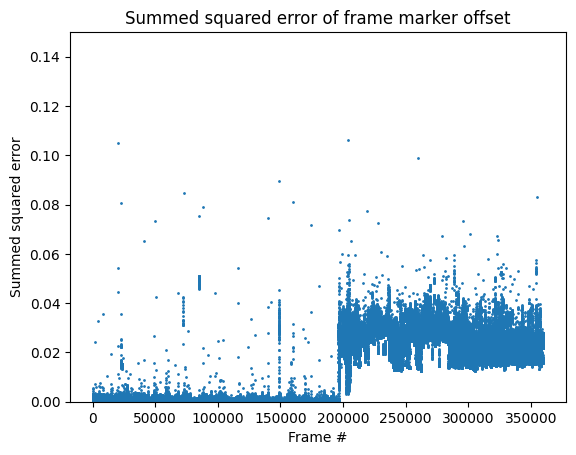

In [54]:
plt.ylim(0, 0.15)
plt.title("Summed squared error of frame marker offset")
plt.xlabel("Frame #")
plt.ylabel("Summed squared error")
x = 360000
plt.scatter(np.arange(x),errors[:x], s=1)

In [55]:
print(f"mean: {errors[:190000].mean()}, std: {errors[:190000].std()}")

mean: 0.000735923764295876, std: 0.0015000818530097604


In [56]:
cutoff = 190000
indices = np.where(errors[:cutoff] > 0.01)[0]

print(f"there are {indices.shape[0]} not good offset frames before the cutoff at {cutoff}")

there are 363 not good offset frames before the cutoff at 190000


(array([1.34237e+05, 4.62870e+04, 7.19200e+03, 1.48500e+03, 2.26000e+02,
        6.70000e+01, 2.80000e+01, 3.10000e+01, 3.70000e+01, 1.40000e+01,
        1.20000e+01, 9.00000e+00, 1.10000e+01, 8.00000e+00, 5.00000e+00,
        4.00000e+00, 3.00000e+00, 4.00000e+00, 2.50000e+01, 3.90000e+01,
        3.70000e+01, 9.00000e+00, 6.00000e+00, 4.00000e+00, 2.00000e+00,
        3.00000e+00, 0.00000e+00, 1.00000e+00, 4.00000e+00, 9.00000e+00,
        3.00000e+00, 3.00000e+00, 3.00000e+00, 6.00000e+00, 4.00000e+00,
        2.00000e+00, 3.00000e+00, 1.20000e+01, 7.00000e+00, 8.00000e+00,
        8.00000e+00, 7.00000e+00, 4.00000e+00, 5.00000e+00, 4.00000e+00,
        3.00000e+00, 4.00000e+00, 6.00000e+00, 5.00000e+00, 4.00000e+00,
        2.00000e+00, 1.00000e+00, 2.00000e+00, 4.00000e+00, 2.00000e+00,
        1.00000e+00, 3.00000e+00, 0.00000e+00, 2.00000e+00, 1.00000e+00,
        1.00000e+00, 5.00000e+00, 8.00000e+00, 1.00000e+01, 2.00000e+00,
        3.00000e+00, 1.00000e+01, 3.00000e+01, 0.00

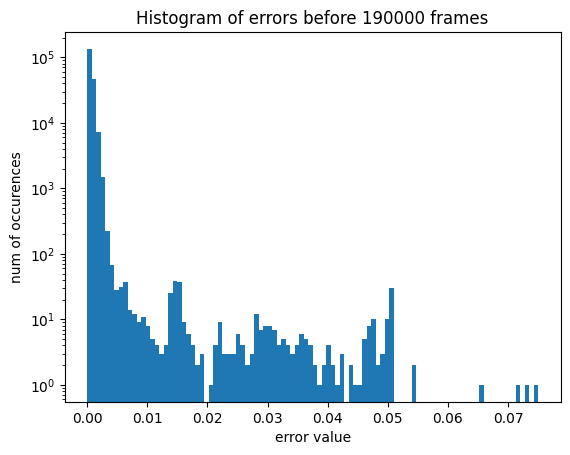

In [57]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(errors[:cutoff], bins=100, range=(0,0.075), log=True)


In [63]:
# Plot a histogram where the values are hte change in qpos from previous to current frame
# Load data
with open(data_path, "rb") as file:
    d = pickle.load(file)
    qposes = np.array(d["qpos"])

qpos_diff = np.diff(qposes, axis=0)

In [64]:
qpos_diff_summed = np.abs(qpos_diff).sum(axis=1)
qpos_diff_summed.shape

(359999,)

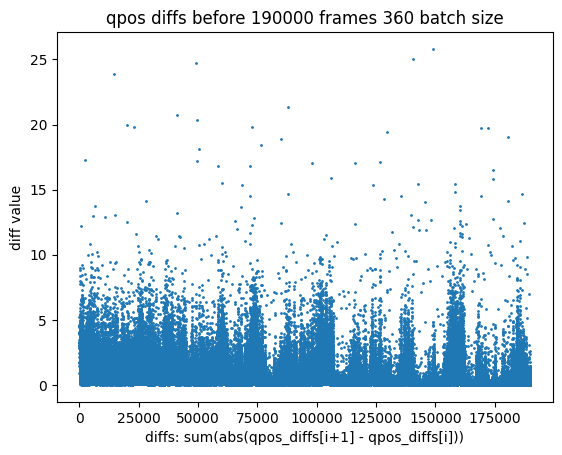

In [65]:
plt.title(f"qpos diffs before {cutoff} frames {360} batch size")
plt.xlabel("diffs: sum(abs(qpos_diffs[i+1] - qpos_diffs[i]))")
plt.ylabel("diff value")
plt.scatter(np.arange(cutoff), qpos_diff_summed[:cutoff], s=1)

In [66]:
# Split qpos_diff_summed into two arrays: one has 10 values for every multiple of 360, 
# and the other one has the rest of the values
# This is to see if the diffs statistics are different between the two
mask = np.array([(i+1)%360 <= 5 for i in range(cutoff)])
qpos_diff_summed_360 = qpos_diff_summed[:cutoff][mask]
qpos_diff_summed_360.shape

(3167,)

(array([980., 472., 334., 205., 165., 115.,  95.,  66.,  66.,  64.,  43.,
         37.,  30.,  34.,  36.,  27.,  18.,  16.,  23.,  18.,  16.,  16.,
         10.,  11.,  11.,  14.,  14.,  11.,  13.,   9.,  11.,   9.,   9.,
          8.,  10.,  13.,  11.,  11.,   8.,  11.,   9.,   3.,   5.,   6.,
          5.,   6.,   3.,   3.,   5.,   5.,   5.,   3.,   3.,   0.,   1.,
          0.,   3.,   1.,   3.,   0.,   0.,   3.,   0.,   2.,   0.,   0.,
          1.,   2.,   3.,   1.,   0.,   0.,   1.,   1.,   0.,   1.,   1.,
          1.,   2.,   3.,   0.,   1.,   0.,   1.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          2.]),
 array([ 0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,  1.75,  2.  ,
         2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,  4.  ,  4.25,
         4.5 ,  4.75,  5.  ,  5.25,  5.5 ,  5.75,  6.  ,  6.25,  6.5 ,
         6.75,  7.  ,  7.25,  7.5 ,  7.75,  8.  ,  8.25,  8.5 ,  8.75,
         9.  ,  9.25,  9.5 ,  9.75

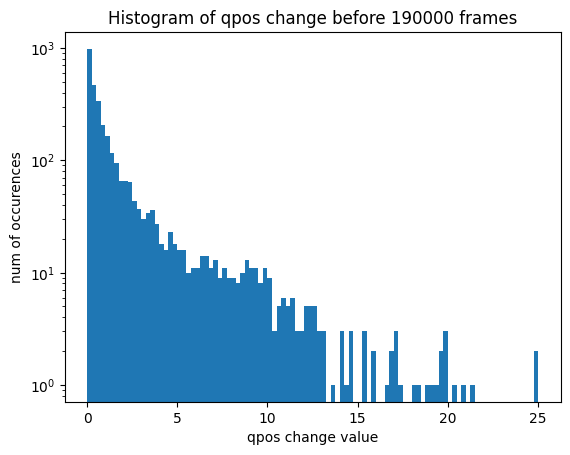

In [67]:
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_360, bins=100, range=(0,25), log=True)

(186833,)


(array([9.5461e+04, 2.8525e+04, 1.6969e+04, 1.1085e+04, 7.7590e+03,
        5.5530e+03, 4.2840e+03, 3.2910e+03, 2.5380e+03, 2.0830e+03,
        1.5690e+03, 1.3070e+03, 1.0500e+03, 8.4500e+02, 6.9800e+02,
        6.1800e+02, 5.6000e+02, 4.0800e+02, 3.8100e+02, 3.0700e+02,
        2.7000e+02, 2.0900e+02, 1.6700e+02, 1.5900e+02, 1.3100e+02,
        1.0400e+02, 1.1000e+02, 6.7000e+01, 6.3000e+01, 5.3000e+01,
        3.8000e+01, 2.4000e+01, 2.6000e+01, 2.1000e+01, 1.3000e+01,
        2.2000e+01, 1.0000e+01, 1.3000e+01, 1.1000e+01, 3.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

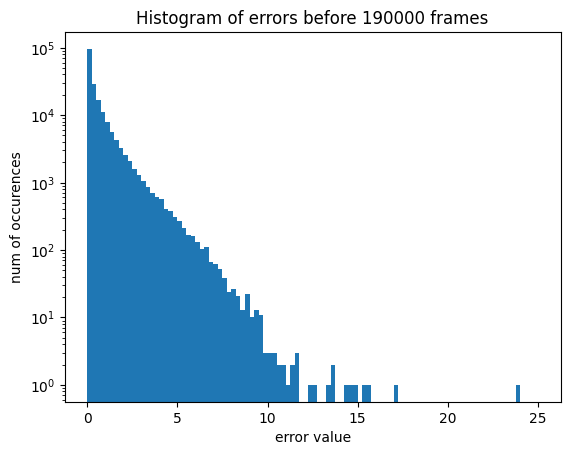

In [68]:
mask = np.array([(i+1)%360 > 5 for i in range(cutoff)])
qpos_diff_summed_mid = qpos_diff_summed[:cutoff][mask]
print(qpos_diff_summed_mid.shape)
# plot graph where x = error value and y = number of frames in log scale
plt.title(f"Histogram of errors before {cutoff} frames")
plt.xlabel("error value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True)

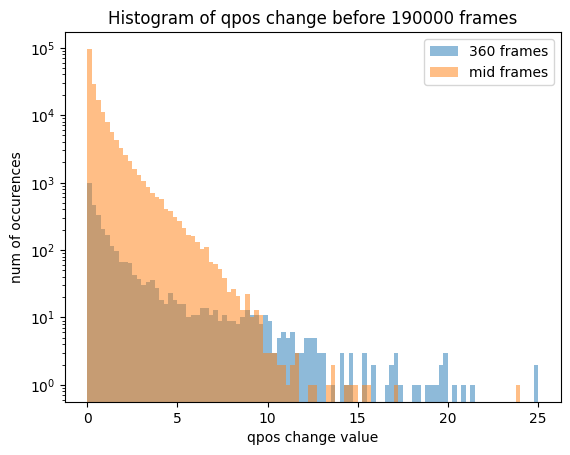

In [69]:
# Overlay the above two histograms 
plt.title(f"Histogram of qpos change before {cutoff} frames")
plt.xlabel("qpos change value")
plt.ylabel("num of occurences")
plt.hist(qpos_diff_summed_360, bins=100, range=(0,25), log=True, alpha=0.5, label="360 frames")
plt.hist(qpos_diff_summed_mid, bins=100, range=(0,25), log=True, alpha=0.5, label="mid frames")
plt.legend()


# view select frame where we have high error

In [22]:
indices[:100]

array([    0,  1440,  3960,  3961,  3962,  3963,  3964,  5040,  5041,
        5042,  7560,  7561,  7562,  7563, 10080, 10081, 10082, 10083,
       10084, 11741, 12600, 12601, 14400, 14401, 16560, 16561, 16562,
       16563, 19800, 19801, 19802, 20880, 20881, 20882, 20883, 20884,
       22680, 22681, 23040, 23041, 23042, 23043, 23044, 23045, 23046,
       23047, 23048, 23049, 23050, 23051, 23052, 23053, 23054, 23055,
       23056, 23057, 23058, 23059, 23060, 23061, 23062, 23063, 23064,
       23065, 23066, 23067, 23068, 23069, 23070, 23071, 23072, 23073,
       23074, 23075, 23076, 23077, 23078, 23079, 24380, 27000, 27720,
       28080, 28081, 28082, 28083, 28084, 28085, 28086, 28087, 28088,
       28089, 28090, 28091, 28092, 28093, 28094, 28095, 28096, 28097,
       28098])

In [66]:
import mediapy as media
from dm_control.mujoco.wrapper.mjbindings import enums
root = mjcf.from_path(model_xml)
physics, mj_model = ctrl.create_body_sites(root)
physics, mj_model, keypoint_sites = ctrl.create_keypoint_sites(root)
renderer = mujoco.Renderer(mj_model)
mj_data = mujoco.MjData(mj_model)
scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = 1
scene_option.sitegroup[2] = 1

scene_option.sitegroup[3] = 1
scene_option.flags[enums.mjtVisFlag.mjVIS_TRANSPARENT] = True
scene_option.flags[enums.mjtVisFlag.mjVIS_LIGHT] = False
scene_option.flags[enums.mjtVisFlag.mjVIS_CONVEXHULL] = True
scene_option.flags[enums.mjtRndFlag.mjRND_SHADOW] = False
scene_option.flags[enums.mjtRndFlag.mjRND_REFLECTION] = False
scene_option.flags[enums.mjtRndFlag.mjRND_SKYBOX] = False
scene_option.flags[enums.mjtRndFlag.mjRND_FOG] = False

""

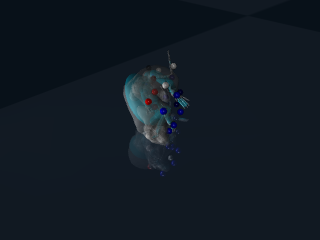

In [78]:
index = 7560
mj_data.qpos = qposes[index]
physics, mj_model = ctrl.set_keypoint_sites(physics, keypoint_sites, kp_data[index])
mujoco.mj_forward(mj_model, mj_data)
renderer.update_scene(mj_data, camera="close_profile", scene_option=scene_option)

media.show_image(renderer.render())